


#### 1. `TEXT PRE PROCESSING` - TOKENIZATION, STOP WORDS REMOVAL, STEMMING.
#### 2. MAKING WORD VECTORS WITH `WORD2VEC`.
#### 3. CONVERTING COLUMNS TO `VECTORS`.
#### 4. GENERATING `CUSTOM FEATURES`.
#### 5. PERFORMING `OVERSAMPLING` DUE TO CLASS IMBALANCE.
#### 6. TRAINING `RANDOM FOREST CLASSIFIER`, `XG BOOST CLASSIFIER`, `RNN` AND `LSTM` MODELS.
#### 7. PERFORMANCE ANALYSIS
#### 8. `INFERENCE` ON TEST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import zipfile

In [ ]:
import gensim
from gensim.models import Word2Vec,KeyedVectors
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

## EXTRACTING DATA

In [ ]:
zip_files = ['/kaggle/input/quora-question-pairs/train.csv.zip',
             '/kaggle/input/quora-question-pairs/test.csv.zip',
             '/kaggle/input/quora-question-pairs/sample_submission.csv.zip']

destination_directory = '/kaggle/working/'

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_directory)

print("Extraction completed.")

Extraction completed.


In [ ]:
data = pd.read_csv("/kaggle/working/train.csv")
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [ ]:
data["is_duplicate"].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [ ]:
data.dropna(inplace = True)

## MAKING CORPUS AND CLEANING THE TEXT

In [ ]:
corpus = data['question1'].tolist() + data['question2'].tolist()

story = []
for sent in tqdm(corpus):
    story.append(simple_preprocess(sent))

100%|██████████| 808574/808574 [00:30<00:00, 26538.81it/s]


In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")

stemmer = PorterStemmer()
def process_word_list(word_list):
    meaningful_words = [
        stemmer.stem(word)  # Apply stemming
        for word in word_list
        if word.lower() not in stopwords.words("english")  # Remove stopwords
    ]
    return meaningful_words

cleaned_story = [process_word_list(sublist) for sublist in tqdm(story)]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████| 808574/808574 [24:39<00:00, 546.46it/s] 


## WORD2VEC


In [ ]:
word2vec_model = gensim.models.Word2Vec(window = 5, min_count = 2, vector_size=30)
word2vec_model.build_vocab(cleaned_story)
word2vec_model.train(cleaned_story,
            total_examples = word2vec_model.corpus_count,
            epochs = word2vec_model.epochs)

(20498405, 21715385)

In [ ]:
data["Ques1_Cleaned"] = cleaned_story[:len(data)]
data["Ques2_Cleaned"] = cleaned_story[len(data):]

In [ ]:
sample_data = data.copy() # INITIALLY USED FOR TAKING SAMPLES OUT OF MAIN DATA
sample_data.reset_index(inplace = True, drop = True)

## GENERATING CUSTOM FEATURES USING TEXT BLOB
* AVG WORD LENGTH
* WORD COUNT
* AVG SENTENCE LENGTH
* FOG INDEX
* COMPLEX WORD COUNT

In [ ]:
from textblob import TextBlob

def text_analysis(word_list):
    # Join the list of words into a text string
    text = " ".join(word_list)

    # Create a TextBlob object
    blob = TextBlob(text)

    # Sentiment Analysis
    polarity_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity

    # Word Metrics
    word_count = len(word_list)
    average_word_length = sum(len(word) for word in word_list) / word_count

    # Sentence Metrics
    sentence_count = len(blob.sentences)
    average_sentence_length = word_count / sentence_count

    # FOG Index
    complex_word_count = len([word for word in word_list if len(word) > 3])
    fog_index = 0.4 * (average_sentence_length + complex_word_count / word_count)

    return np.array([average_word_length, word_count, average_sentence_length, fog_index, complex_word_count])

## CONVERTING TEXT COLUMN INTO VECTORS

In [ ]:
vec1 = np.zeros((len(sample_data), 30))
vec2 = np.zeros((len(sample_data), 30))
other_features = np.zeros((len(sample_data), 10))

for i in tqdm(range(len(sample_data))):

    text1 = sample_data["Ques1_Cleaned"][i]
    text2 = sample_data["Ques2_Cleaned"][i]

    if len(text1) != 0:
        vec1[i] = (sum([word2vec_model.wv[word] for word in text1 if word in word2vec_model.wv.index_to_key]) / len(text1))
        blob1 = text_analysis(text1)
    else:
        vec1[i] = np.zeros((30,))
        blob1 = np.zeros((5,))
    if len(text2) != 0:
        vec2[i] = (sum([word2vec_model.wv[word] for word in text2 if word in word2vec_model.wv.index_to_key]) / len(text2))
        blob2 = text_analysis(text2)
    else:
        vec2i = np.zeros((30,))
        blob2 = np.zeros((5,))
    other_features[i] = np.concatenate([blob1, blob2])

100%|██████████| 404287/404287 [11:58<00:00, 562.33it/s]


In [ ]:
sample_data = pd.concat([sample_data,
                        pd.DataFrame(vec1, columns = np.arange(0, 30)),
                        pd.DataFrame(vec2, columns = np.arange(30, 60)),
                        pd.DataFrame(other_features, columns = np.arange(60, 70))], axis = 1)
sample_data

,id,qid1,qid2,question1,question2,is_duplicate,Ques1_Cleaned,Ques2_Cleaned,0,1,...,60,61,62,63,64,65,66,67,68,69
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",-1.404709,-0.939719,...,4.857143,7.0,7.0,3.200000,7.0,4.833333,6.0,6.0,2.800000,6.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[stori, kohinoor, koh, noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",-0.116453,-0.505728,...,5.400000,5.0,5.0,2.320000,4.0,5.400000,10.0,10.0,4.360000,9.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dn]",-0.291087,-0.701349,...,5.500000,6.0,6.0,2.666667,4.0,5.200000,5.0,5.0,2.320000,4.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mental, lone, solv]","[find, remaind, math, math, divid]",0.976941,-2.259914,...,4.666667,3.0,3.0,1.600000,3.0,4.800000,5.0,5.0,2.400000,5.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolv, water, quikli, sugar, salt, met...","[fish, would, surviv, salt, water]",0.216572,-0.344723,...,4.800000,10.0,10.0,4.320000,8.0,4.800000,5.0,5.0,2.400000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404282,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[mani, keyword, racket, program, languag, late...","[mani, keyword, perl, program, languag, latest...",0.205543,1.352938,...,6.285714,7.0,7.0,3.200000,7.0,6.000000,7.0,7.0,3.200000,7.0
404283,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[believ, life, death]","[true, life, death]",2.408487,-2.919700,...,5.000000,3.0,3.0,1.600000,3.0,4.333333,3.0,3.0,1.600000,3.0
404284,404287,537928,537929,What is one coin?,What's this coin?,0,"[one, coin]",[coin],1.306625,-0.745744,...,3.500000,2.0,2.0,1.000000,1.0,4.000000,1.0,1.0,0.800000,1.0
404285,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,"[approx, annual, cost, live, studi, uic, chica...","[littl, hairfal, problem, want, use, hair, sty...",-0.014881,-0.115936,...,5.333333,9.0,9.0,3.955556,8.0,4.692308,13.0,13.0,5.476923,9.0


## OVERSAMPLING

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
xresampled, yresampled = smote.fit_resample(sample_data.iloc[:,8:], sample_data["is_duplicate"])
xresampled.shape, yresampled.shape

((510048, 70), (510048,))

## MODELING

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
xtrain, xtest, ytrain, ytest = train_test_split(xresampled, yresampled, test_size = 0.2)
xtrain.shape, ytrain.shape

((408038, 70), (408038,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(xtrain, ytrain)
rf_model.score(xtest, ytest)

0.8559356925791589

In [ ]:
import xgboost as xg
xg_model = xg.XGBClassifier()
xg_model.fit(xtrain, ytrain)
xg_model.score(xtest, ytest)

0.8056857170865601

In [ ]:
import joblib

joblib.dump(rf_model, 'rf_model.joblib')
joblib.dump(xg_model, 'xg_model.joblib')

['xg_model.joblib']

In [ ]:
loaded_rf_model = joblib.load('/kaggle/working/rf_model.joblib')
loaded_xg_model = joblib.load('/kaggle/working/xg_model.joblib')

## PERFORMANCE ANALYSIS

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

ypred1 = rf_model.predict(xtest)
ypred2 = xg_model.predict(xtest)
conf_matrix1 = confusion_matrix(ytest, ypred1)
conf_matrix2 = confusion_matrix(ytest, ypred2)

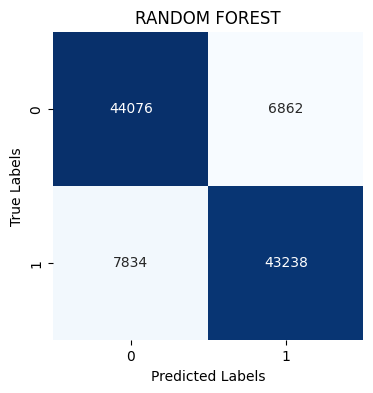

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RANDOM FOREST')
plt.show()

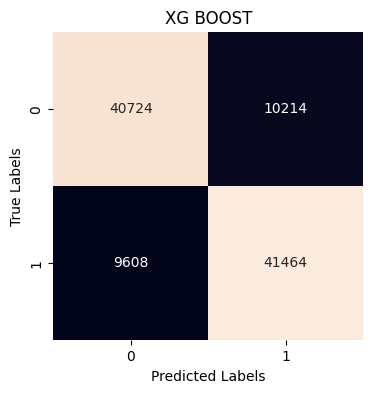

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XG BOOST')
plt.show()

In [ ]:
class_report1 = pd.DataFrame(classification_report(ytest, ypred1, output_dict = True))
class_report2 = pd.DataFrame(classification_report(ytest, ypred2, output_dict = True))
class_report1

,0,1,accuracy,macro avg,weighted avg
precision,0.849085,0.863034,0.855936,0.856059,0.856069
recall,0.865287,0.846609,0.855936,0.855948,0.855936
f1-score,0.857110,0.854742,0.855936,0.855926,0.855924
support,50938.000000,51072.000000,0.855936,102010.000000,102010.000000


In [ ]:
class_report2

,0,1,accuracy,macro avg,weighted avg
precision,0.809108,0.802353,0.805686,0.805730,0.805726
recall,0.799482,0.811873,0.805686,0.805678,0.805686
f1-score,0.804266,0.807085,0.805686,0.805675,0.805677
support,50938.000000,51072.000000,0.805686,102010.000000,102010.000000


## SAMPLE INFERENCE

### SINGLE PREDICTION

In [ ]:
# sample1 = 'What are some common examples of solid matter?'
# sample2 = 'What are the most common examples of solid matter?'

l = 13242
sample1 = data["question1"][l]
sample2 = data["question2"][l]
sample1, sample2, data["is_duplicate"][l]

('What are some notable examples of Freudian slips?',
 'Is the Freudian approach to the human condition valid?',
 0)

In [ ]:
def inference(sample1, sample2):
    inf_text1 = process_word_list(sample1.split())
    inf_text2 = process_word_list(sample2.split())

    inf_vec1 = np.zeros((1, 30))
    inf_vec2 = np.zeros((1, 30))
    inf_other_features = np.zeros((1, 10))

    if len(inf_text1) != 0:
        inf_vec1[0] = (sum([word2vec_model.wv[word] for word in inf_text1 if word in word2vec_model.wv.index_to_key]) / len(inf_text1))
        inf_blob1 = text_analysis(inf_text1)
    else:
        inf_vec1[0] = np.zeros((30,))
        inf_blob1 = np.zeros((5,))
    if len(inf_text2) != 0:
        inf_vec2[0] = (sum([word2vec_model.wv[word] for word in inf_text2 if word in word2vec_model.wv.index_to_key]) / len(inf_text2))
        inf_blob2 = text_analysis(inf_text2)
    else:
        inf_vec2[0] = np.zeros((30,))
        inf_blob2 = np.zeros((5,))
    inf_other_features[0] = np.concatenate([inf_blob1, inf_blob2])

    inf_data = pd.DataFrame({})
    inf_data = pd.concat([inf_data,
                            pd.DataFrame(inf_vec1, columns = np.arange(0, 30)),
                            pd.DataFrame(inf_vec2, columns = np.arange(30, 60)),
                            pd.DataFrame(inf_other_features, columns = np.arange(60, 70))], axis = 1)
    return inf_data

inf_data = inference(sample1, sample2)
inf_data

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.32874,-0.326298,-0.5386,-0.195656,-0.05017,0.20025,0.614054,-0.194912,-0.672896,0.314957,...,6.5,4.0,4.0,2.0,4.0,6.6,5.0,5.0,2.4,5.0


In [ ]:
out = rf_model.predict(inf_data)

if out == 0:
    print("DIFFERENT")
else:
    print("DUPLICATE")

DIFFERENT


### PREDICTION ON SAMPLE DATA

In [ ]:
sam = data.sample(10).iloc[:,3:6]
sam.reset_index(inplace = True, drop = True)
sam

,question1,question2,is_duplicate
0,What is corporate SIM?,How does a SIM card work?,0
1,What are the steps to get the UAN number for m...,How do I check my UAN number?,0
2,What is difference between App (Application) a...,What is the difference between a software and ...,1
3,What are some signs that someone is trustworth...,What are some signs that someone is not trustw...,1
4,Should I buy a laptop with AMD A10-8700P or In...,"Can a Windows 10 ,64 bit laptop with i5 6 th g...",0
5,What is the purpose of introducing the 2000 no...,Why did RBI choose to come out with a ₹2000 no...,0
6,Why has Google fallen behind in self driving c...,Who is ahead in the race to sell self-driving ...,0
7,Even if god does exist why should anyone worsh...,Why does Almighty God need people to worship him?,1
8,I worked in .net 6+ yrs n now I shifted to Bus...,What would be the expense for MS in Canada?,0
9,Are there any people living in india who have ...,Has anybody visited all the countries in the w...,1


In [ ]:
outs = []
for k in range(len(sam)):
    sample1 = sam["question1"][k]
    sample2 = sam["question2"][k]
    inf_data = inference(sample1, sample2)
    outs.append(rf_model.predict(inf_data)[0])
sam["Predictions"] = outs
sam

,question1,question2,is_duplicate,Predictions
0,What is corporate SIM?,How does a SIM card work?,0,0
1,What are the steps to get the UAN number for m...,How do I check my UAN number?,0,0
2,What is difference between App (Application) a...,What is the difference between a software and ...,1,0
3,What are some signs that someone is trustworth...,What are some signs that someone is not trustw...,1,1
4,Should I buy a laptop with AMD A10-8700P or In...,"Can a Windows 10 ,64 bit laptop with i5 6 th g...",0,0
5,What is the purpose of introducing the 2000 no...,Why did RBI choose to come out with a ₹2000 no...,0,0
6,Why has Google fallen behind in self driving c...,Who is ahead in the race to sell self-driving ...,0,0
7,Even if god does exist why should anyone worsh...,Why does Almighty God need people to worship him?,1,1
8,I worked in .net 6+ yrs n now I shifted to Bus...,What would be the expense for MS in Canada?,0,0
9,Are there any people living in india who have ...,Has anybody visited all the countries in the w...,1,0


### PREDICTION ON TEST SET

In [ ]:
# test_data = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
# sample = pd.read_csv("/kaggle/working/sample_submission.csv")
# test_data

In [ ]:
# outs = []
# for k in tqdm(range(len(test_data))):
#     sample1 = test_data["question1"][k]
#     sample2 = test_data["question2"][k]
#     inf_data = inference(sample1, sample2)
#     outs.append(rf_model.predict(inf_data)[0])
# sample["Predictions"] = outs
# sample.drop("is_duplicate", axis = 1)
# sample

# RNN - DL APPROACH

## MAKING TOKENIZED SEQUENCES

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
xresampled_dl, yresampled_dl = ros.fit_resample(data.iloc[:,3:5], data["is_duplicate"])
xresampled_dl.shape, yresampled_dl.shape

((510048, 2), (510048,))

In [ ]:
que1 = np.array(xresampled_dl['question1'].tolist())
que2 = np.array(xresampled_dl['question2'].tolist())

docx = []
for i in tqdm(range(len(que1))):
    docx.append(que1[i] + " " + que2[i])

100%|██████████| 510048/510048 [00:04<00:00, 110479.33it/s]


In [ ]:
lengths = []
for sent in tqdm(docx):
    lengths.append(len(sent.split()))

100%|██████████| 510048/510048 [00:01<00:00, 385729.65it/s]


<Axes: ylabel='Density'>

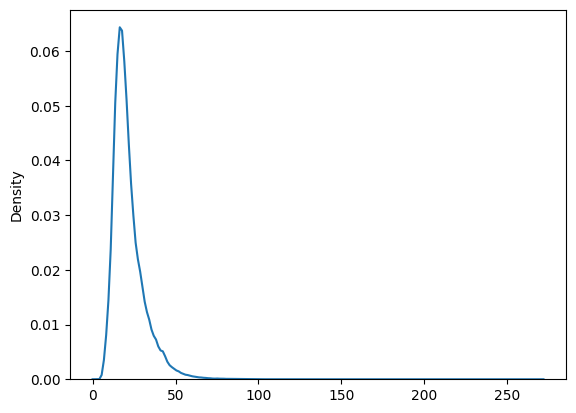

In [ ]:
sns.kdeplot(lengths) # TO SEE, AROUND WHICH NUMBER THE MOST SENTENCE LENGHTS LIES

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(oov_token = "<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding = "post", maxlen = 35)

## MODEL ARCHITECTURE

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(sequences.max()+1, output_dim = 30, input_length = 35))
model.add(tf.keras.layers.SimpleRNN(32, return_sequences = False))
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 30)            2867910   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2016      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,869,959
Trainable params: 2,869,959
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])
history = model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)

Epoch 1/20
409/409 [==============================] - 21s 47ms/step - loss: 0.5527 - accuracy: 0.7210 - val_loss: 0.8322 - val_accuracy: 0.4802
Epoch 2/20
409/409 [==============================] - 19s 47ms/step - loss: 0.4620 - accuracy: 0.7830 - val_loss: 0.5281 - val_accuracy: 0.7403
Epoch 3/20
409/409 [==============================] - 19s 47ms/step - loss: 0.3895 - accuracy: 0.8216 - val_loss: 0.3269 - val_accuracy: 0.8828
Epoch 4/20
409/409 [==============================] - 19s 46ms/step - loss: 0.3345 - accuracy: 0.8501 - val_loss: 0.3009 - val_accuracy: 0.8883
Epoch 5/20
409/409 [==============================] - 19s 46ms/step - loss: 0.2925 - accuracy: 0.8704 - val_loss: 0.4398 - val_accuracy: 0.7870
Epoch 6/20
409/409 [==============================] - 19s 45ms/step - loss: 0.2598 - accuracy: 0.8865 - val_loss: 0.2382 - val_accuracy: 0.9185
Epoch 7/20
409/409 [==============================] - 19s 48ms/step - loss: 0.2308 - accuracy: 0.9005 - val_loss: 0.1971 - val_accuracy:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

max_seq_length = 35
vocab_size = sequences.max() + 1

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_seq_length))
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           9559700   
                                                                 
 bidirectional (Bidirectiona  (None, 35, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 35, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 35, 1)             129       
                                                                 
Total params: 9,644,309
Trainable params: 9,644,309
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Assuming `tokenizer` is your already fitted Tokenizer object
num_tokens = len(tokenizer.word_counts)
print("Number of tokens:", num_tokens)


Number of tokens: 95595


In [ ]:
history2 = lstm_model.fit(sequences, yresampled_dl,
         epochs = 20, batch_size = 1000,
         validation_split = 0.2)


Epoch 1/20
409/409 [==============================] - 225s 549ms/step - loss: 0.3973 - accuracy: 0.8069 - val_loss: 0.4709 - val_accuracy: 0.7681
Epoch 2/20
409/409 [==============================] - 216s 529ms/step - loss: 0.3675 - accuracy: 0.8213 - val_loss: 0.4759 - val_accuracy: 0.7528
Epoch 3/20
409/409 [==============================] - 220s 537ms/step - loss: 0.3407 - accuracy: 0.8349 - val_loss: 0.4113 - val_accuracy: 0.8142
Epoch 4/20
409/409 [==============================] - 217s 530ms/step - loss: 0.3177 - accuracy: 0.8465 - val_loss: 0.4196 - val_accuracy: 0.7881
Epoch 5/20
409/409 [==============================] - 217s 530ms/step - loss: 0.2977 - accuracy: 0.8571 - val_loss: 0.3376 - val_accuracy: 0.8632
Epoch 6/20
409/409 [==============================] - 225s 550ms/step - loss: 0.2785 - accuracy: 0.8674 - val_loss: 0.4373 - val_accuracy: 0.7709
Epoch 7/20
409/409 [==============================] - 223s 545ms/step - loss: 0.2619 - accuracy: 0.8760 - val_loss: 0.2891 -

## INFERENCE

In [ ]:
def inference_dl(sam1, sam2):
    docx = [sam1 + " " + sam2]
    sequences = tokenizer.texts_to_sequences(docx)
    sequences = pad_sequences(sequences, padding = "post", maxlen = 35)
    return sequences

In [ ]:
l = 13243
sample1 = data["question1"][l]
sample2 = data["question2"][l]
sample1, sample2, data["is_duplicate"][l]

('Which one is grammatically correct: "an year" or "a year"?',
 'The atmosphere seem to be that of a friendly one. Is this phrase grammatically correct?',
 0)

In [ ]:
sample1 = "Who is the most liked character of all time"
sample2 = 'Which character is the most liked one'

In [ ]:
inf_data = inference_dl(sample1, sample2)
out = lstm_model.predict(inf_data, verbose = 0)
out = tf.squeeze(out)
out = "DUPLICATE" if np.mean(out) >= 0.5 else "DIFFERENT"
out

'DUPLICATE'

In [ ]:
sam = data.sample(10).iloc[:,3:6]
sam.reset_index(inplace = True, drop = True)
sam

,question1,question2,is_duplicate
0,Can I go to the US while working in Infosys or...,Which IT company offers the highest pay to fre...,0
1,How imminent is World War three?,Do you think we are on the verge of World War ...,1
2,What is the most probable cutoff of KVPY SA 2016?,How many questions did you attempt and how man...,1
3,Is there any need to join class for spoken Eng...,How can I become fluent in English?,0
4,What is the best thing to learn in software de...,What is the most important thing you learned i...,1
5,What is something that I don't know but you do?,What is something that you do not know?,0
6,How is a hedge fund different from a mutual fund?,What are the differences between a hedge fund ...,1
7,What is the best Social Media management tool?,What are some social media management tools?,1
8,"What is the salary offered to a SDE-I, SDE-II ...",What designation and CTC does flipkart offer i...,0
9,How can I recover lost data on a Note 3?,How do I recover lost data in laptop?,0


In [ ]:
outs = []
for k in range(len(sam)):
    sample1 = sam["question1"][k]
    sample2 = sam["question2"][k]
    inf_data = inference_dl(sample1, sample2)
    out = lstm_model.predict(inf_data, verbose = 0)
    out = tf.squeeze(out)
    out = 1 if np.mean(out) >= 0.5 else 0
    outs.append(out)
sam["Predictions"] = outs
sam

,question1,question2,is_duplicate,Predictions
0,Can I go to the US while working in Infosys or...,Which IT company offers the highest pay to fre...,0,0
1,How imminent is World War three?,Do you think we are on the verge of World War ...,1,1
2,What is the most probable cutoff of KVPY SA 2016?,How many questions did you attempt and how man...,1,1
3,Is there any need to join class for spoken Eng...,How can I become fluent in English?,0,0
4,What is the best thing to learn in software de...,What is the most important thing you learned i...,1,1
5,What is something that I don't know but you do?,What is something that you do not know?,0,0
6,How is a hedge fund different from a mutual fund?,What are the differences between a hedge fund ...,1,1
7,What is the best Social Media management tool?,What are some social media management tools?,1,1
8,"What is the salary offered to a SDE-I, SDE-II ...",What designation and CTC does flipkart offer i...,0,0
9,How can I recover lost data on a Note 3?,How do I recover lost data in laptop?,0,0


## TEST SET

In [ ]:
# test_data = pd.read_csv("/kaggle/input/quora-question-pairs/test.csv")
# sample = pd.read_csv("/kaggle/working/sample_submission.csv")
# test_data

In [ ]:
# outs = []
# for k in tqdm(range(len(test_data))):
#     sample1 = test_data["question1"][k]
#     sample2 = test_data["question2"][k]
#     inf_data = inference_dl(sample1, sample2)
#     out = lstm_model.predict(inf_data, verbose = 0)
#     out = tf.squeeze(out)
#     out = 1 if np.mean(out) >= 0.5 else 0
# #     if out > 0.5:
# #         out = 1
# #     else:
# #         out = 0
#     outs.append(out)
# sample["Predictions"] = outs
# sample.drop("is_duplicate", axis = 1)
# sample